<a href="https://colab.research.google.com/github/dbwilburn/BIOC5721/blob/main/Gaw_Law_Simulation_in_Python_AU24_HW1_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BIOC5721 - Physical Biochemistry I**
## Particle Simulator Example
DBW/RME 2024-08-28

To make best use of this notebook, Edit > Clear all outputs, then run desired cells sequentially

For example, this is a **markdown cell** where information can be written and formatted in various ways using different flags. They are useful for embedding different types of important textual data to accompany your source code.

Text can be **bolded**, _italicized_, and formatted to look like `code`, rendered as a $\frac{Latex}{equation}$, as well as other options. You can double click on this cell to see formatting procedures.

### This notebook includes code for a *Particle Simulator* to understand the principles of the ideal gas law and examples of basic data analysis/visualization.

Install and load required libraries

In [1]:
# Confirm libraries are installed on the system
!pip install numpy pandas scipy matplotlib

# Load libraries
import numpy as np, pandas as pd # Numerical and data frame libraries
import matplotlib.pyplot as plt # Plotting library
import scipy.stats as stats # General statistics package


In [2]:
#@title Particle Simulator Code (can ignore if you desire, but must click the > run arrow)

## Particle simulation classes

class Particle:
    def __init__(self, position, velocity, mass):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.mass = mass

    def move(self, dt):
        # Update position based on velocity
        self.position += self.velocity * dt


    def collide_with_wall(self, box_size):
        # Check for collisions with walls and reflect velocity
        collision = 0.0
        for i in range(len(self.position)):
            if self.position[i] <= 0 or self.position[i] >= box_size[i]:
                self.velocity[i] *= -1
                collision += np.abs(self.velocity[i]) * 2
                self.position[i] = np.clip(self.position[i], 0, box_size[i])
        return collision



class Particle_Simulator:
    def __init__(self, size, n_particles, velocity_scalar=1.0, mass=1.0):
        self.size = np.array(size, dtype=float)
        self.n_dim = len(self.size)
        if self.n_dim <= 2:
            self.area = 2*np.sum(self.size)
        elif self.n_dim == 3:
            self.area = 2*np.sum(self.size*np.roll(self.size,1))

        self.particles = [Particle(position=np.random.rand(self.n_dim) * size,
                                   velocity=np.random.normal(loc=0, scale=velocity_scalar, size=self.n_dim),
                                   mass=mass)
                          for _ in range(n_particles)] # Randomly initialize starting positions and velocities
        self.pressure = 0
        self.temperature = 0

    def update(self, dt):
        # Reset pressure for this time step
        self.pressure = 0
        total_kinetic_energy = 0

        for particle in self.particles:
            particle.move(dt)

            # Calculate kinetic energy: 1/2 * m * v^2
            kinetic_energy = 0.5 * particle.mass * np.sum(particle.velocity ** 2)
            total_kinetic_energy += kinetic_energy / 1.5

            # Calculate pressure contribution from wall collisions
            self.pressure += particle.collide_with_wall(self.size) / dt / self.area

        # Calculate temperature as proportional to average kinetic energy
        #self.temperature = total_kinetic_energy / (len(self.particles) * 1.5)
        self.temperature = total_kinetic_energy

    def simulate(self, final_time, dt=0.01, verbose=True): # Default dt = 10 ms
        # Prepare storage for positions, temperatures, and pressures
        positions_over_time = [[] for _ in range(len(self.particles))]
        temperatures = []
        pressures = []
        times = np.arange(dt, final_time+dt, dt) # dt to time in steps of dt
        for t in times:
            self.update(dt)
            temperatures.append(self.temperature)
            pressures.append(self.pressure)

            for i, particle in enumerate(self.particles):
                positions_over_time[i].append(particle.position.copy())
        if verbose:
            print('Simulation complete!')
        return times, positions_over_time, temperatures, pressures

Perform a single simulation and compute statistics on pressure

In [3]:
## Simulation parameters
box_size = [10, 10]
n_particles = 1000
velocity_scalar = 50.0
simulation_time = 20.0
dt = 0.01 # 1e-4 of the run time

sim = Particle_Simulator(size=box_size,
                         n_particles=n_particles,
                         velocity_scalar=velocity_scalar)

times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)


Simulation complete!


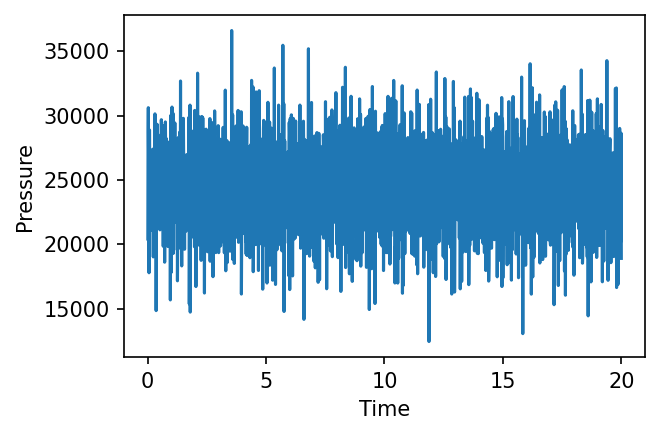

In [4]:
# Plot pressure vs time

fig, ax = plt.subplots(figsize=(4.5,3), dpi=150)
ax.plot(times, pressures)
ax.set_xlabel('Time')
ax.set_ylabel('Pressure')
fig.tight_layout()


Pressure mean = 24449.41
Pressure std = 3404.72


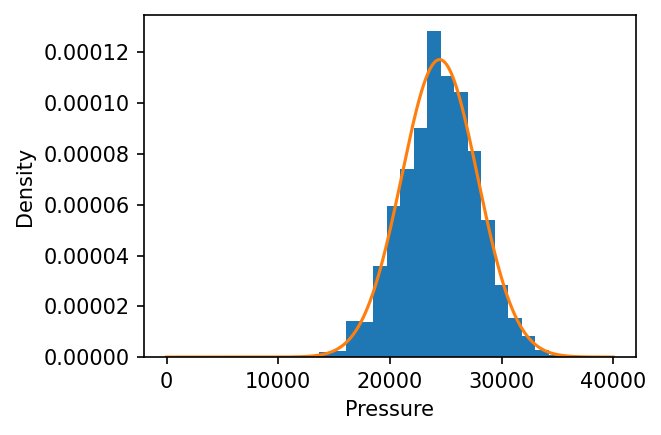

In [5]:
# Plot the distribution of pressure values and add basic statistics

fig, ax = plt.subplots(figsize=(4.5,3), dpi=150)
ax.hist(pressures, bins=20, density=True)

# Add Gaussian PDF
min_p = 0
max_p = 4e4
n_pts = int(1e4)
p_pts = np.linspace(min_p, max_p, n_pts)
p_mean = np.mean(pressures)
p_std = np.std(pressures, ddof=1)
weighted_pdf = stats.norm.pdf(p_pts, p_mean, p_std)
ax.plot(p_pts, weighted_pdf)
ax.set_xlabel('Pressure')
ax.set_ylabel('Density')
fig.tight_layout()

print(f"Pressure mean = {p_mean:.2f}\nPressure std = {p_std:.2f}")

We will now perform a series of simulations altering the number of particles and computing mean pressure

In [6]:
## Common simulation parameters
box_size = [10, 10]
simulation_time = 10.0
velocity_scalar = 50.0
dt = 0.01 # 1e-4 of the run time

## Generate range of n_particles
list_of_n_particles = list(range(100, 1100, 100))
mean_pressures = []
for n_particles in list_of_n_particles:
    sim = Particle_Simulator(size=box_size,
                             n_particles=n_particles,
                             velocity_scalar=velocity_scalar)
    times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)
    mean_pressures.append(np.mean(pressures))



Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!


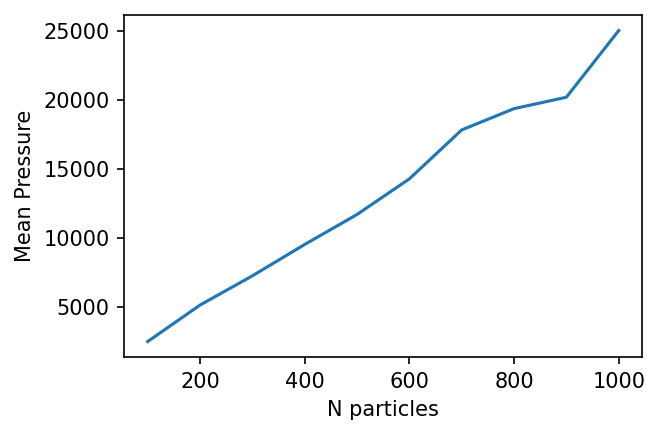

In [8]:
# Plot mean pressure vs n_particles

fig, ax = plt.subplots(figsize=(4.5,3), dpi=150)
ax.plot(list_of_n_particles, mean_pressures)
ax.set_xlabel('N particles')
ax.set_ylabel('Mean Pressure')
fig.tight_layout()
